In [ ]:
'''
tokenizers and torchdata need to be installed
pip install tokenizers
pip install torchdata
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import math

from typing import Tuple
from torch import Tensor
from torchtext.datasets import Multi30k
from torch.utils.data import DataLoader
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.processors import TemplateProcessing
from copy import deepcopy

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

In [ ]:
SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))

f = open("parallelcorpus.txt", "a")

for i in train_iter:
  for x in [x.rstrip("\n") for x in i]:
    f.write(x)
    f.write(' ')

f.close()

In [ ]:
MAX_LEN = 64
VOCAB_SIZE = 32768
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
BATCH_SIZE = 64

tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=["[UNK]", "[PAD]", "[BOS]", "[EOS]"])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.train(['parallelcorpus.txt'], trainer)

tokenizer.enable_padding(pad_id=1, length=MAX_LEN)
tokenizer.post_processor = TemplateProcessing(
    single="[BOS] $A [EOS]",
    special_tokens=[
        ("[BOS]", tokenizer.token_to_id("[BOS]")),
        ("[EOS]", tokenizer.token_to_id("[EOS]")),
    ],
)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_enc = tokenizer.encode(src_sample.rstrip("\n"))
        src_batch.append(torch.tensor(src_enc.ids))

        tgt_enc = tokenizer.encode(tgt_sample.rstrip("\n"))
        tgt_batch.append(torch.tensor(tgt_enc.ids))
    return torch.stack(src_batch), torch.stack(tgt_batch)

In [ ]:
test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataloader = DataLoader(train_iter, batch_size = BATCH_SIZE, collate_fn=collate_fn)
test_dataloader = DataLoader(test_iter, batch_size = BATCH_SIZE, collate_fn=collate_fn)

In [ ]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_size, pad_mask):
        super(Embedding, self).__init__()
        self.emb = nn.Embedding(vocab_size, embedding_size, padding_idx=pad_mask)

    def forward(self, x):
        x = x.to(device)
        return self.emb(x)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.d_ff = d_ff
        self.d_k = self.d_v = int(d_model / d_h)
        self.dropout = nn.Dropout(dropout)
        self.Linear = nn.Linear(d_model, d_model) # Linear Layer for the concatenated head
        self.normalize = nn.LayerNorm(d_model) # Normalizing Layer
        self.feed_forward = nn.Sequential( # Feed Forward Layer
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)])

    def forward(self, x):
        heads = []
        for i in range(self.d_h):
            Q = self.linears[3*i](x) # Query Matrix
            K = self.linears[3*i + 1](x) # Key Matrix
            V = self.linears[3*i + 2](x) # Value Matrix
            scaledMatMul = Q @ K.transpose(-1, -2) / math.sqrt(self.d_k) # Matrix mul. of Q and K.T -> Scale
            head = F.softmax(scaledMatMul, dim=2) @ V # Softmax
            heads.append(head) # A Single Head
        Z = self.Linear(torch.cat((heads), -1)) # Concatenated heads -> Linear Layer
        Z = self.normalize(x + self.dropout(Z)) # Output of the First Add&Norm Layer
        Z = self.normalize(self.feed_forward(Z) + Z) # 1st Add&Norm -> Feed Forward -> 2nd Add&Norm
        return Z

In [ ]:
class EncoderStack(nn.Module):
    def __init__(self, d_model, d_ff, d_h, dropout, N):
        super(EncoderStack, self).__init__()
        self.encoders = nn.ModuleList([EncoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Encoder Layer N Times

    def forward(self, x):
        for encoder in self.encoders:
            x = encoder(x)
        return x

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model=512, d_ff=2048, d_h=8, dropout=0.1): # parameters={}
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.d_k = self.d_v = int(self.d_model / self.d_h)
        self.linears = nn.ModuleList([nn.Linear(d_model, self.d_k) for _ in range(d_h*3)]) # linear layers
        self.firstLinear = nn.Linear(d_h * self.d_v, d_model) # linear layer for the concatenated head
        self.secondLinear = nn.Linear(d_h * self.d_model, d_model) # linear layer for the concatenated head(second multi-head attention)
        self.normalize = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential( # Feed Forward Layer
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y, mask):
        heads1 = []
        heads2 = []

        # FIRST ATTENTION LAYER
        ''' Same as encoder, but here we have tgt(target) as the decoder's input '''
        for i in range(self.d_h):
            Q = self.linears[3*i](y) # Query Matrix
            K = self.linears[3*i+1](y) # Key Matrix
            V = self.linears[3*i+2](y) # Value Matrix
            scaledMatMul = Q @ K.transpose(-1, -2) / math.sqrt(self.d_k) # Matrix mul. of Q and K.T -> Scale
            maskedMat = scaledMatMul + mask # Masking
            soft = F.softmax(maskedMat, dim=2) # Softmax
            head =  soft @ V
            heads1.append(head) # Appending a single head
        Z1 = self.firstLinear(torch.cat((heads1), dim=-1)) # Concatenated heads of the First Attention Layer
        Z1 = self.normalize(y + self.dropout(Z1)) # First Normalizing Layer

        # SECOND ATTENTION LAYER
        ''' Attention layer, instead of V and K matrices, we use the output of the encoder '''
        for i in range(self.d_h):
            scaledMat = Z1 @ x.transpose(-1, -2) / math.sqrt(self.d_k) # Matrix mul. of Q and K.T -> Scale
            soft = F.softmax(scaledMat, dim=2) # Softmax
            head = soft @ x
            heads2.append(head) # Appending a single head
        Z2 = self.secondLinear(torch.cat((heads2), dim=-1)) # Concatenated heads of the Second Attention Layer
        Z2 = self.normalize(Z1 + Z2) # Second Normalizing Layer
        Z2 = self.normalize(self.feed_forward(Z2) + Z2) # Feed Forward -> Normalize
        Z2 = self.dropout(Z2)
        return Z2

In [ ]:
class DecoderStack(nn.Module):
    def __init__(self, d_model, d_ff, d_h, dropout, N):
        super(DecoderStack, self).__init__()
        self.decoders = nn.ModuleList([DecoderLayer(d_model, d_ff, d_h, dropout) for _ in range(N)]) # Stacking Decoder Layer N Times

    def forward(self, x, y, mask):
        for decoder in self.decoders:
            y = decoder(x, y, mask)
        return y

In [ ]:
class Transformer(nn.Module):
    def __init__(self, embedding_size=512, d_model=512, d_h = 8, d_ff=2048, vocab_size=32768, dropout=0.1, num_coder_layers=6):
        super(Transformer, self).__init__()
        self.d_model = d_model
        self.d_h = d_h
        self.linear = nn.Linear(d_model, vocab_size)
        self.dropoutEnc = nn.Dropout(dropout)
        self.dropoutDec = nn.Dropout(dropout)
        self.embed = Embedding(vocab_size, embedding_size, pad_mask=1)
        self.encoderStack = EncoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)
        self.decoderStack = DecoderStack(d_model, d_ff, d_h, dropout, num_coder_layers)

    def Mask(self, batch_dim):
        size = self.d_model // self.d_h
        mask = torch.triu(torch.tensor([[[-np.inf for _ in range(size)] for _ in range(size)] for _ in range(batch_dim)]), diagonal=1).to(device)
        return mask

    def PositionalEncoding(self, seq_len, d_model, n):
        P = torch.zeros(seq_len, d_model)
        for k in range(seq_len):
            for i in range(int(d_model/2)):
                denominator = math.pow(n, 2*i/d_model)
                P[k, 2*i] = math.sin(k/denominator)
                P[k, 2*i+1] = math.cos(k/denominator)
        P = P.to(device)
        return P

    def forward(self, x, y):
        batch_dim = x.shape[0]
        mask = self.Mask(batch_dim)
        x, y = self.embed(x), self.embed(y)
        pos_encoding = self.PositionalEncoding(self.d_model//self.d_h, self.d_model, 10000)
        x, y = pos_encoding + x, pos_encoding + y
        x, y = self.dropoutEnc(x), self.dropoutDec(y)
        encoderOutput = self.encoderStack(x)
        decoderOutput = self.decoderStack(encoderOutput, y, mask)
        logits = self.linear(decoderOutput)
        probs = F.log_softmax(logits, dim=-1)
        return probs

In [ ]:
model = Transformer(embedding_size=512, d_model=512, d_h=8, d_ff=2048, vocab_size=VOCAB_SIZE, dropout=0.1, num_coder_layers=6).to(device)

In [ ]:
def train_and_eval(model: nn.Module, train_data: DataLoader, test_data: DataLoader, learning_rate: int, decay_rate: int, momentum: int, padding_idx: int, epoch_num: int, max_len: int):

    criterion = nn.NLLLoss(ignore_index=padding_idx)
    
    graph_x_loss = []
    graph_y_loss = []
    graph_x_acc = []
    graph_y_acc = []

    for epoch in range(1, epoch_num+1):

        decayed_lr = (1 / (1 + decay_rate*(epoch-1))) * learning_rate
        '''TODO: try Adam optimization instead of SGD''' 
        optimizer = optim.SGD(model.parameters(), lr=decayed_lr, momentum=momentum)

        print("#"*31)
        print(f'##Training begins for epoc {epoch:>2}##')
        print("#"*31)

        total_loss = 0
        loss_arr = []

        for i, (src, tgt) in enumerate(train_data):

            if i == 10:
                break

            src, tgt = src.to(device), tgt.to(device)
            optimizer.zero_grad()
            probs = model(src, tgt).permute(0, 2, 1)
            loss = criterion(probs, tgt)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            if i % 50 == 0:
                loss_per_batch = total_loss / 50
                print(f'Number of batches: {i:>4}|    Loss per batch: {loss_per_batch:>5.3f}')
                print("-"*60)
                loss_arr.append(loss_per_batch)
                total_loss = 0
    
        avg_loss = np.average(loss_arr)
        graph_x_loss.append(epoch)
        graph_y_loss.append(avg_loss)
        print(f'Training is complete for epoch {epoch:>2}, average loss for epoch {epoch:>2}: {avg_loss:>5.3f}')
        print("-"*60)

        acc_per_batch=0
        test_data_size=0

        for src_test, tgt_test in test_data:
            if test_data_size==2:
                break
            test_data_size+=1
            src_test, tgt_test = src_test.to(device), tgt_test.to(device)
            probs = model(src_test, tgt_test)
            pred = torch.argmax(probs, dim=2)
            pred_arr = pred.cpu().numpy()
            tgt_test_arr = tgt_test.cpu().numpy()
            similar_idx_ratio=0
            batch_size = tgt_test.shape[0]

            for i in range(batch_size):
                
                pad_idx_count = np.sum(tgt_test_arr[i] == 1)
                sentence_len = max_len - pad_idx_count
                similar_idx_ratio += np.sum(pred_arr[i][:sentence_len]==tgt_test_arr[i][:sentence_len]) / sentence_len
    
            average_similar_idx = similar_idx_ratio / batch_size
            acc_per_batch += average_similar_idx
    
        total_acc = (acc_per_batch / test_data_size)*100
        graph_x_acc.append(epoch)
        graph_y_acc.append(total_acc)
        print(f'Accuracy is {total_acc:>5.2f} % for epoch {epoch:>2}')
        print("\n")
    
    print("Loss graph: ")
    plt.plot(graph_x_loss, graph_y_loss, color='blue')
    plt.title("Loss Graph")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Loss Per Epoch")
    plt.show()

    print("\n")

    print("Accuracy Graph: ")
    plt.plot(graph_x_acc, graph_y_acc, color='green')
    plt.title("Accuracy Graph")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy Per Epoch")
    plt.show

###############################
##Training begins for epoc  1##
###############################
Number of batches:   50|    Loss per batch: 6.676
------------------------------------------------------------
Number of batches:  100|    Loss per batch: 4.812
------------------------------------------------------------
Number of batches:  150|    Loss per batch: 4.208
------------------------------------------------------------
Number of batches:  200|    Loss per batch: 3.765
------------------------------------------------------------
Number of batches:  250|    Loss per batch: 3.526
------------------------------------------------------------
Number of batches:  300|    Loss per batch: 3.342
------------------------------------------------------------
Number of batches:  350|    Loss per batch: 3.096
------------------------------------------------------------
Number of batches:  400|    Loss per batch: 3.087
------------------------------------------------------------
Number of batche

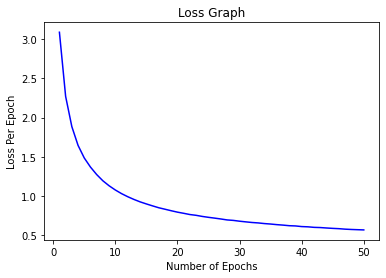



Accuracy Graph: 


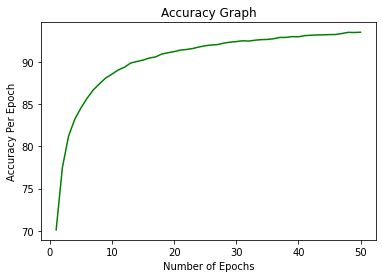

In [17]:
train_and_eval(model, train_dataloader, test_dataloader, learning_rate=0.003, decay_rate=0.1, momentum=0.9, padding_idx=PAD_IDX, epoch_num=50, max_len=MAX_LEN)